In [1]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.8
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [2]:
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to c:\users\pc\appdata\local\temp\pip-req-build-d5qwt65h
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0-cp37-none-any.whl size=78915 sha256=7bd8bd694e8f272079e13443bc5560b3a659ff9201b136d57813aade5efcf072
  Stored in directory: C:\Users\PC\AppData\Local\Temp\pip-ephem-wheel-cache-to6kou9h\wheels\eb\1b\35\fce87697be00d2fc63e0b4b395b0d9c7e391a10e98d9a0d97f
Successfully built tensorflow-docs


  Running command git clone -q https://github.com/tensorflow/docs 'C:\Users\PC\AppData\Local\Temp\pip-req-build-d5qwt65h'


In [3]:
%matplotlib inline

In [4]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [5]:
import os
import random
import numpy as np
import pandas as pd
import pathlib
import seaborn as sns
import matplotlib.pyplot as plt
#from IPython.core.display import SVG



In [6]:
from pathlib import Path
import IPython.display as display
from PIL import Image
from skimage.io import imread

from tensorflow.keras.preprocessing import image 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from numpy import expand_dims

import tensorflow as tf
from tensorflow import keras

from tensorflow_docs.plots import HistoryPlotter

from tensorflow.keras.layers import Add, Input, BatchNormalization, Conv2D, MaxPool2D, Activation, GlobalAveragePooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.initializers import he_uniform #get article link, explain why I use this
from tensorflow.keras.regularizers import l1, l2

from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping, LearningRateScheduler


# Classification of blinding retinal diseases using ResNet Blocks and Convolutional Layers

### *Abstract*

In this project, we compare three neural networks for classifying correctly three different retinal diseases. Our data consists of more than 32 thousand **optical coherence tomography** (OCT) images of the retina separated equally in four classes across train/val/test datasets.

Two of our neural networks consist of a combination of resnet layers and convolutional layers. The third network is a plain convolutional network. We use Global Average Pooling(GAP) and no fully connected (FC) layers in all of the models. 

The best training loss that we achieve is 9.88% on the shallower architecture with residual blocks. We had a problem with overfitting during the whole process. Tuning was focused on adjusting the learning rate.



### *Data*

*Spectral-domain OCT uses light to capture high-resolution in vivo optical cross-sections of the retina that can be assembled into three-dimensional-volume images of living retinal tissue. It has become one of the most commonly performed medical imaging procedures, with approximately 30 million OCT scans performed each year worldwide (Swanson and Fujimoto, 2017). OCT imaging is now a standard of care for guiding the diagnosis and treatment of some of the leading causes of blindness worldwide: age-related macular degeneration (AMD) and diabetic macular edema.
Almost 10 million individuals suffer from AMD in the United States, and each year, more than 200,000 people develop choroidal neovascularization, a severe blinding form of advanced AMD (Ferrara, 2010, Friedman et al., 2004, Wong et al., 2014). In addition, nearly 750,000 individuals aged 40 or older suffer from diabetic macular edema (Varma et al., 2014), a vision-threatening form of diabetic retinopathy that involves the accumulation of fluid in the central retina. The prevalence of these diseases will likely increase even further over time due to the aging population and the global diabetes epidemic.* 
(source: http://www.cell.com/cell/fulltext/S0092-8674(18)30154-5) 

![alt text](OCT_image.png "Representative OCT Images")
Figure 1: Credit: http://www.cell.com/cell/fulltext/S0092-8674(18)30154-5

Above: (Far left) choroidal neovascularization (**CNV**) with a neovascular membrane (white arrowheads) and associated subretinal fluid (arrows). (Middle left) Diabetic macular edema (**DME**) with retinal-thickening-associated intraretinal fluid (arrows). (Middle right) Multiple **drusen** (arrowheads) present in early AMD. (Far right) **Normal** retina with preserved foveal contour and absence of any retinal fluid/edema.

Our four classes: CNV, DME, DRUSEN, NORMAL are separated into train/val/test datasets - 7200/800/200 scans for each class 

- Dataset source = https://www.kaggle.com/paultimothymooney/kermany2018/data#

# Working with data

In [7]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

### Constants

In [8]:
#constants
DATA_DIR = os.path.abspath("../oct_data_2017/") #we save it all here

#directories to different datasets
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
VAL_DIR = os.path.join(DATA_DIR, 'val')
TEST_DIR = os.path.join(DATA_DIR, 'test')

#target image size for our models
IMG_SIZE = [224, 224]

#class names saved to be used for labeling
CLASS_NAMES = ['cnv', 'dme', 'drusen', 'normal']

#initial batch size for our models
BATCH_SIZE = 64

#initial epochs count for the models
EPOCHS = 30

---

In [9]:
data_dir = pathlib.Path(DATA_DIR)
train_dir = pathlib.Path(TRAIN_DIR)
val_dir = pathlib.Path(VAL_DIR)
test_dir = pathlib.Path(TEST_DIR)

In [10]:
#get the file paths
list_train = tf.data.Dataset.list_files(str(train_dir/'*/*'))
list_val = tf.data.Dataset.list_files(str(val_dir/'*/*'))
list_test = tf.data.Dataset.list_files(str(test_dir/'*/*'))

In [11]:
print('Train data count: ', len(list(list_train)))
print('Validation data count: ', len(list(list_val)))
print('Test data count: ', len(list(list_test)))

Train data count:  28800
Validation data count:  3200
Test data count:  800


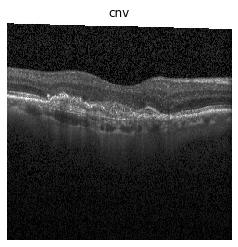

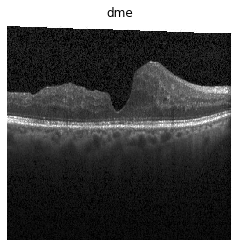

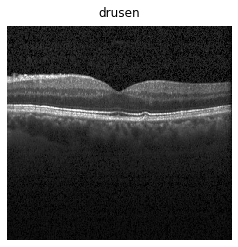

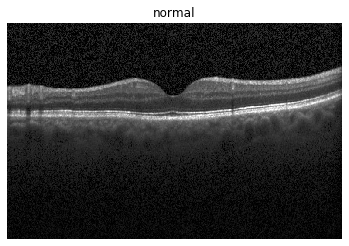

In [12]:
#show some images for verification
for c in CLASS_NAMES:
    type_image = list(train_dir.glob(c + '/*'))
    for image_path in type_image[:1]:
        plt.title(c)
        plt.imshow(Image.open(str(image_path)), cmap = 'gray')
        plt.axis('off')
    plt.show()

In [13]:
for f in list_test.take(5):
    print(f.numpy())

b'E:\\Google Drive\\Project Colab\\oct_data_2017\\test\\cnv\\CNV-827677-1.jpeg'
b'E:\\Google Drive\\Project Colab\\oct_data_2017\\test\\drusen\\DRUSEN-5094722-1.jpeg'
b'E:\\Google Drive\\Project Colab\\oct_data_2017\\test\\cnv\\CNV-204397-1.jpeg'
b'E:\\Google Drive\\Project Colab\\oct_data_2017\\test\\cnv\\CNV-103044-7.jpeg'
b'E:\\Google Drive\\Project Colab\\oct_data_2017\\test\\cnv\\CNV-1083927-1.jpeg'


# Functions for data processing

In [14]:
def show_batch(image_batch, label_batch):
    """Show a slice of batch images to check if batches consist of images from
    different classes.
    Using for-loop to detect and show image class.
    """
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(np.squeeze(image_batch[n]), cmap = 'gray')
        ix = 0
        for a in label_batch[n]:
            if a == 1:
                break;
            else:
                ix+=1
        plt.title(CLASS_NAMES[ix].title())
        plt.axis('off')   

In [15]:
def get_label(file_path):
    """Convert file path of the image to a list of path components.
    Return the class of the image, which is the second to the last in the list.
    """
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == CLASS_NAMES

In [16]:
def process_path(file_path):
    label = get_label(file_path)
      # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    #img = decode_img(img)
    return img, label

When performing the preprocessing of our images we had to consider the fact that some images have white areas on the edges. Also, our images are of different dimensions. We have considered the option to crop the images in the center and try to remove as much of the white areas as possible. But we have to think about the test images that may be checked by our models. If they also consist of white areas, this may become an issue for our model. So we proceeded with rescale and resize function. 

In [17]:
def map_data(data):
    """ Preprocessing data:
    - Decode JPEG-encoded image to a uint8 tensor
    - Adjust the contrast of the images by random factor
    - Cast and rescale
    - Resize
    """
    data = data.map(lambda x, y: (tf.image.decode_jpeg(x, channels = 1), y))
    data = data.map(lambda x, y: (tf.image.random_contrast(x, 0.8, 1), y)) 
    #data = data.map(lambda x, y: (tf.image.random_brightness(x, 0.2), y))
    data = data.map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y))
    #data = data.map(lambda x, y: (tf.image.central_crop(x, 0.85), y)) better performance without it
    data = data.map(lambda x, y:(tf.image.resize(x, IMG_SIZE), y))
    #data = data.map(lambda x, y:  (x, tf.cast(y, tf.int32)))
    return data

In [18]:
def prepare_for_training(ds, cache = True, shuffle_buffer_size = 3000):
    """Facilitate model training by setting batch size and prefetch
    """
    # Use 'cache(filename)' to cache preprocessing work for datasets that don't fit in memory
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()
    
    ds = ds.shuffle(buffer_size = shuffle_buffer_size) # reshuffle_each_iteration = True
    
    # Repeat forever
    ds = ds.repeat()
    
    ds = ds.batch(BATCH_SIZE)
    
    # 'Prefetch' lets the dataset fetch batches in the background while the model is training.
    
    ds = ds.prefetch(buffer_size = AUTOTUNE)
    
    return ds

# Data processing 

In [19]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
labeled_train = list_train.map(process_path, num_parallel_calls=AUTOTUNE)
labeled_val = list_val.map(process_path, num_parallel_calls=AUTOTUNE)
labeled_test = list_test.map(process_path, num_parallel_calls=AUTOTUNE)

In [20]:
labeled_train = map_data(labeled_train)
labeled_val = map_data(labeled_val)
labeled_test = map_data(labeled_test)

We have grayscale images, so the image shape should have only one channel. The label/class is presented as an array with True/False values (one True class always), which compared to the CLASS_NAMES array will return the name of the label in each image in the show_batch() function.

In [21]:
for image, label in labeled_train.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (224, 224, 1)
Label:  [False  True False False]


In [22]:
train_dataset = prepare_for_training(labeled_train)
train_dataset

<DatasetV1Adapter shapes: ((None, 224, 224, 1), (None, 4)), types: (tf.float32, tf.bool)>

In [23]:
val_dataset = prepare_for_training(labeled_val)
val_dataset

<DatasetV1Adapter shapes: ((None, 224, 224, 1), (None, 4)), types: (tf.float32, tf.bool)>

In [24]:
test_dataset = prepare_for_training(labeled_test)
test_dataset

<DatasetV1Adapter shapes: ((None, 224, 224, 1), (None, 4)), types: (tf.float32, tf.bool)>

In [25]:
image_batch, label_batch = next(iter(train_dataset))

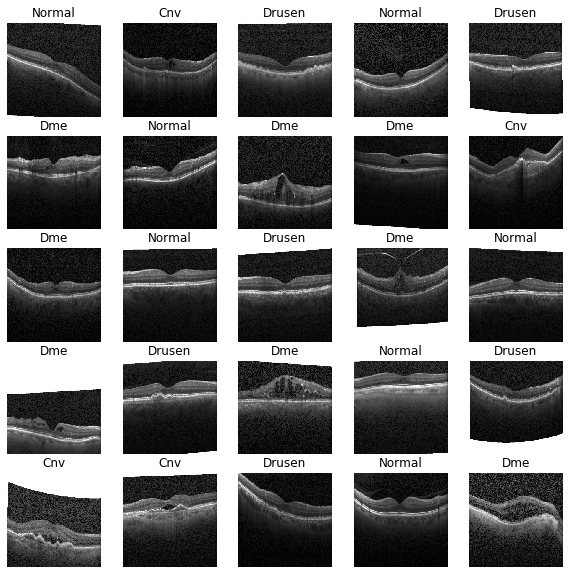

In [26]:
show_batch(image_batch.numpy(), label_batch.numpy())

# Functions to make model creation and compiling easier

In [27]:
def get_optimizer(lr):
    return Adam(learning_rate = lr)

In [28]:
def get_data_to_csv(hist_model, model_name):
    hist = pd.DataFrame(hist_model.history)
    hist.to_csv(model_name + '.csv')

    return pd.read_csv(model_name + '.csv', usecols = ['loss','accuracy', 'val_loss', 'val_accuracy'])

## Callbacks

In [29]:
def get_modelcheckpoint(checkpoint_prefix):
    
    checkpoint_callback = ModelCheckpoint(
        filepath = checkpoint_prefix,
        save_weights_only = True,
        save_freq = 'epoch')
    return checkpoint_callback

In [30]:
def get_tensorboard_callback(model_name):
    
    tensorboard_callback = TensorBoard(
        log_dir = 'tensorboard_logs\\'+ model_name,
        histogram_freq = 5,
        write_graph = True,
        update_freq = 'epoch')
    return tensorboard_callback

In [31]:
#we do not want our model to overfit infinitely
earlystopping_callback = EarlyStopping(
    monitor = 'val_loss', 
    patience = 5) 

In [32]:
def learning_rate_scheduler(scheduler):
    callback_lr = LearningRateScheduler(scheduler)
    return callback_lr


In [33]:
# Directory where the checkpoints will be saved
checkpoint_dir = 'training_checkpoints'

---

## Compile and fit

Originally the residual learning framework's purpose is to facilitate the training of very deep networks. The authors of the paper "Deep Residual Learning for Image Recognition" (https://arxiv.org/pdf/1512.03385.pdf) "*reformulate the layers as learning residual functions with reference to the layer inputs*", in other words, remind the deeper layers what happened earlier.

Since the resnet structure is interesting we would like to apply it to shallower models and compare the difference where we have a framework consisting of residual blocks and a simple convolutional network. Possible future development of this project and the classification task we have here would be to create a deeper residual network and/or apply transfer learning.

The authors of the above-mentioned paper explain *degradation problem*: when the network depth increases, accuracy gets saturated and then degrades rapidly. The problem is not caused by overfitting. The deep residual learning framework actually addresses it.

We would not be facing this problem in our work, again because our models are shallow but it is good to know the roots for the idea.

### Now we move on to explain the residual block and framework structure which inspired our models.

If we denote the desired mapping as $ \mathcal{H}(x) $ the stacked nonlinear layers fit the mapping

$$ \large \mathcal{F}(x) := \mathcal{H}(x) - x $$

The original mapping is recast into 
$$ \large \mathcal{F}(x) + x $$

The above formulation transformed in the feedforward neural network with so-called "*shortcut connections*" - skipping one or more layers. The shortcut connections perform *identity* mapping and their output is added to the outputs of the stacked layers. Identity shortcut connections add neither new parameter nor make the computations more complex. The way we explain it is that their purpose is to act as a regularizer. They "remind" to our network what happened not so long time ago.

![alt text](residual_building_block.png "Residual building block")
Figure 2: Residual learning: building block.Credit: https://arxiv.org/pdf/1512.03385.pdf

A building block is defined as: 

$$ \large y = \mathcal{F}(x, {\{W_i\}}) + x $$,

where x and y are input and output vectors of the layers and the function $ \mathcal{F}(x, {W_i})$ represents the residual mapping to be learned. 
The operation $\mathcal {F} + x $ is performed by a shortcut connection and element-wise addition. The second nonlinearity comes after the addition.
Important notice that has to be made here is that the dimensions of $ x $ and $\mathcal {F}$ must be equal. If this is not the case, we can perform a linear projection $W_s$ by the shortcut connections to match the dimensions:

$$ \large y = \mathcal {F}(x, {\{W_i\}}) + {W_s}x$$

## Network Architectures
![alt text](models_blocks.jpg "Models Blocks")
Figure 3: Architectures of the three models we use in this project

Applies to all models - Instead of fully connected layer for output, we use **1x1 convolution**, followed by **Global Average Pooling(GAP)** and **softmax** activation.

GAP - According to Min Lin et al. (https://arxiv.org/pdf/1312.4400.pdf), the fully connected layers are prone to overfitting, which could affect negatively the generalization ability of the neural network. GAP allows replacing FC layers with a convolutional layer when returning the output. For this purpose, we use a convolutional layer with a number of features equal to the number of classes in our classification task. We use the global average pooling to take the average of each feature map which is then fed directly into the softmax layer. In the resnet models, we use dropout before GAP to improve more the generalization ability of our models.

In Plain Conv, every convolutional layer is followed by a batch normalization. 

ReLu activation is used for the hidden layers.

#### There are two types of residual building blocks:
**Three layers skip connection** 
   - Input
   - Conv Layer 1 x 1
   - Conv Layer s x s (size from variable)
   - Conv Layer 1 x 1
   - Transform input with 1 x 1 convolution (dimensions must be the same to add)
   - Add Input to the Output of the three convolutional blocks
   
 Batch normalization is applied after each convolution and before activation

**Two layers skip connection**
   - Input
   - Conv Layer 1 x 1
   - Conv Layer s x s (size from variable)
   - Add Input to the Output of the three convolutional blocks
   
 Batch normalization is applied after each convolution and before activation

---

# ResNet Blocks

In [34]:
def res_net_block3(input_data, conv_size, stage, block, filters):
    """Structure:
    - Input
    - Conv Layer 1 x 1
    - Conv Layer s x s (size from variable)
    - Conv Layer 1 x 1
    - Transform input with 1 x 1 convolution
    - Add Input to the Output of the three convolutional blocks
    
    -> "Same" padding is used everywhere.
    -> he_uniform is used as kernel_initializer.
    -> Batch normalization is applied after each convolution and before activation.
    
    """
    conv_name_base = 'res_' + str(stage) + block + '_branch_'
    bn_name_base = 'bn_' + str(stage) + block + '_branch_'
    F1, F2, F3 = filters
    
    x = input_data
    
    #conv block 1
    x = Conv2D(filters=F1, 
               kernel_size = (1, 1), 
               strides = (1, 1), 
               padding = 'same', 
               name = conv_name_base + 'a', kernel_initializer = he_uniform())(x)   
    x = BatchNormalization(name = bn_name_base + 'a')(x)
    x = Activation('relu')(x)
    
    #conv block 2
    x = Conv2D(filters=F2, 
               kernel_size = conv_size, 
               strides = (1, 1), 
               padding = 'same', 
               name = conv_name_base + 'b', kernel_initializer = he_uniform())(x)              
    x = BatchNormalization(name = bn_name_base + 'b')(x)
    x = Activation('relu')(x)
    
    #conv block 3
    x = Conv2D(filters=F3, 
               kernel_size = (1, 1), 
               strides = (1, 1), 
               padding = 'same', 
               name = conv_name_base + 'c', kernel_initializer = he_uniform())(x)   
    x = BatchNormalization(name = bn_name_base + 'c')(x)
    
    #1x1 convolution on the input, so we can perform the shortcut connection/projection shortcut
    input_data = Conv2D(filters=F3, 
                        kernel_size = (1, 1),
                        padding = 'same', 
                        name = conv_name_base + '1', kernel_initializer = he_uniform())(input_data)
    
    x = Add()([x, input_data])
    
    x = Activation('relu')(x)
    return x


In [35]:
def res_net_block2(input_data, conv_size, stage, block, filter_size):
    
    """Structure:
    - Input
    - Conv Layer 1 x 1
    - Conv Layer s x s (size from variable)
    - Add Input to the Output of the three convolutional blocks
    
    -> "Same" padding is used everywhere.
    -> he_uniform is used as kernel_initializer.
    -> Batch normalization is applied after each convolution and before activation.
    
    """
    conv_name_base = 'res_' + str(stage) + block + '_branch_'
    bn_name_base = 'bn_' + str(stage) + block + '_branch_'
    
    x = input_data
    
    x = Conv2D(filters=filter_size, 
               kernel_size = conv_size, 
               strides = (1, 1), 
               padding = 'same', 
               name = conv_name_base + 'd', kernel_initializer = he_uniform())(x)  
    x = BatchNormalization(name = bn_name_base + 'd')(x)
    x = Activation('relu')(x)
    
    x = Conv2D(filters=filter_size, 
               kernel_size = conv_size, 
               strides = (1, 1), 
               padding = 'same', 
               name = conv_name_base + 'e', kernel_initializer = he_uniform())(x)   
    x = BatchNormalization(name = bn_name_base + 'e')(x)

    x = Add()([x, input_data])
    
    x = Activation('relu')(x)
    return x

---

# Models

In [36]:
# save our models history

save_histories = {}

## ResNet_L

In [37]:
# Name of the checkpoint files
resnet_l_checkpoint = os.path.join(checkpoint_dir, "resnet_l_ckpt_{epoch}")

In [38]:
#ResNet_L

inputs = Input(shape = (224, 224, 1))

#conv 1
model = Conv2D(filters = 64, 
               kernel_size = 7, strides = 2, padding = 'same', 
               name = 'conv_1_7x7', kernel_initializer = he_uniform())(inputs)
model = BatchNormalization(name = 'bn_1')(model)
model = Activation('relu')(model)

#conv 2
model = Conv2D(filters = 64, 
               kernel_size = 5, padding = 'same', 
               name = 'conv_2_5x5', kernel_initializer = he_uniform())(model)
model = BatchNormalization(name = 'bn_2')(model)
model = Activation('relu')(model)

#decrease dimensions
model = MaxPool2D(pool_size = 3, strides = 2)(model)

#resnet 1
model = res_net_block2(model, 3, 1, 'a', 64)

#resnet 2
model = res_net_block3(model, 3, 2, 'b', filters = [64, 64, 128])

#decrease dimensions 
model = Conv2D(filters = 128, 
               kernel_size = 3, strides = 2, padding = 'valid', 
               activation = 'relu', 
               name = 'conv_3_3x3', kernel_initializer = he_uniform())(model) 
#resnet 3
model = res_net_block2(model, 3, 3, 'c', 128)

#resnet 4
model = res_net_block3(model, 3, 4, 'd', filters = [128, 128, 256])

#1x1 conv block substituting fully connected layer exit
model = Conv2D(filters = 4, 
               kernel_size = 1, 
               strides = 1, 
               name = 'conv_output_1x1', 
               kernel_initializer = he_uniform())(model)
model = Dropout(0.2)(model)
model = BatchNormalization(name = 'bn_output')(model)
model = GlobalAveragePooling2D()(model)
classifications = Activation('softmax')(model)

In [39]:
resnet_l = Model(inputs = inputs, outputs = classifications)

In [40]:
resnet_l.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 1) 0                                            
__________________________________________________________________________________________________
conv_1_7x7 (Conv2D)             (None, 112, 112, 64) 3200        input_1[0][0]                    
__________________________________________________________________________________________________
bn_1 (BatchNormalization)       (None, 112, 112, 64) 256         conv_1_7x7[0][0]                 
__________________________________________________________________________________________________
activation (Activation)         (None, 112, 112, 64) 0           bn_1[0][0]                       
______________________________________________________________________________________________

In [50]:
resnet_l.compile(optimizer = get_optimizer(0.001),
                  loss = CategoricalCrossentropy(),
                  metrics=['accuracy'])

In [51]:
save_histories['ResNet_L'] = resnet_l.fit(
    train_dataset, 
    epochs = EPOCHS,
    validation_data = val_dataset,
    steps_per_epoch = len(list(list_train))//BATCH_SIZE, 
    validation_steps = len(list(list_val))//BATCH_SIZE,
    initial_epoch = 0,
    callbacks = [get_modelcheckpoint(resnet_l_checkpoint),
                get_tensorboard_callback('ResNet_L'),
                earlystopping_callback])

Train for 450 steps, validate for 50 steps
Epoch 1/30
450/450 [==============================] - 86s 192ms/step - loss: 0.7918 - accuracy: 0.8132 - val_loss: 0.6999 - val_accuracy: 0.8531
Epoch 2/30
450/450 [==============================] - 84s 187ms/step - loss: 0.4964 - accuracy: 0.9145 - val_loss: 0.6606 - val_accuracy: 0.7922
Epoch 3/30
450/450 [==============================] - 85s 188ms/step - loss: 0.3745 - accuracy: 0.9341 - val_loss: 0.3889 - val_accuracy: 0.8944
Epoch 4/30
450/450 [==============================] - 85s 188ms/step - loss: 0.2973 - accuracy: 0.9467 - val_loss: 0.2805 - val_accuracy: 0.9337
Epoch 5/30
450/450 [==============================] - 85s 188ms/step - loss: 0.2479 - accuracy: 0.9536 - val_loss: 0.4579 - val_accuracy: 0.8344
Epoch 6/30
450/450 [==============================] - 85s 189ms/step - loss: 0.2043 - accuracy: 0.9618 - val_loss: 0.2766 - val_accuracy: 0.9231
Epoch 7/30
450/450 [==============================] - 85s 189ms/step - loss: 0.1729 - a

In [54]:
#resnet_l_model_path = "model_save\\resnet_l"
#resnet_l.save(resnet_l_model_path) 

INFO:tensorflow:Assets written to: model_save\resnet_l\assets


In [39]:
resnet_data  = pd.read_csv('ResNet_L.csv', usecols = ['loss', 'accuracy', 'val_loss','val_accuracy'])                                 
#= get_data_to_csv(save_histories.get('ResNet_L'), 'ResNet_L') #yep the model name needs to be in a constant
resnet_data.sample()

,loss,accuracy,val_loss,val_accuracy
18,0.032893,0.993542,0.141699,0.962188


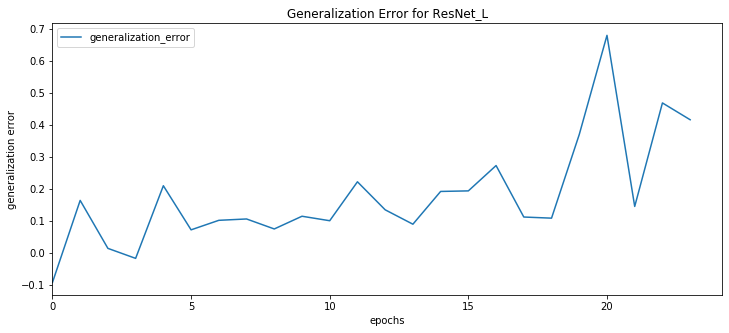

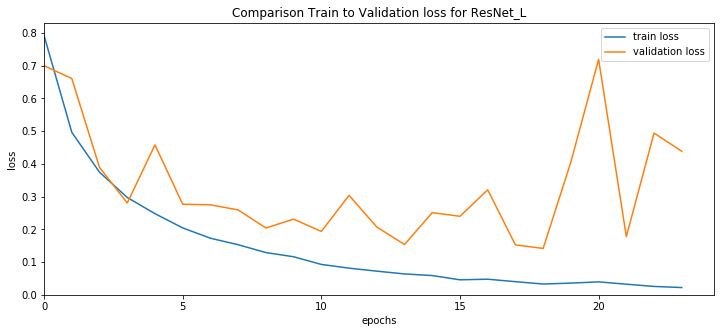

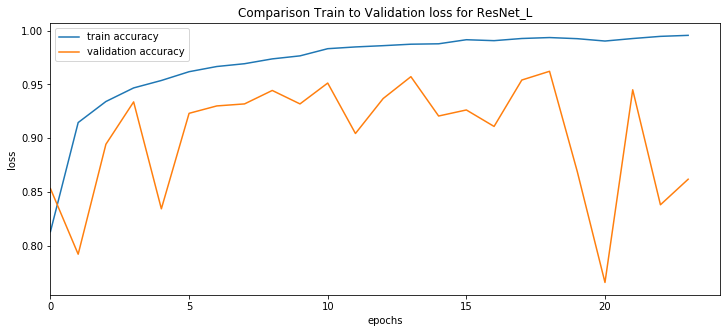

In [40]:
generalization_error_resnet_l = resnet_data.val_loss - resnet_data.loss

#plot
plt.figure(figsize=(12,5))
plt.plot(generalization_error_resnet_l, label='generalization_error')
plt.title("Generalization Error for ResNet_L")
plt.xlabel('epochs')
plt.ylabel('generalization error')
plt.xlim(xmin = 0)
plt.legend()
plt.show()

plt.figure(figsize=(12,5))
plt.plot(resnet_data.loss, label = 'train loss')
plt.plot(resnet_data.val_loss, label = 'validation loss')
plt.title("Comparison Train to Validation loss for ResNet_L")
plt.xlabel('epochs')
plt.ylabel('loss')
plt.xlim(xmin = 0)
plt.ylim(ymin = 0)
plt.legend()
plt.show()

plt.figure(figsize=(12,5))
plt.plot(resnet_data.accuracy, label = 'train accuracy')
plt.plot(resnet_data.val_accuracy, label = 'validation accuracy')
plt.title("Comparison Train to Validation loss for ResNet_L")
plt.xlabel('epochs')
plt.ylabel('loss')
plt.xlim(xmin = 0)

plt.legend()
plt.show()

---

## Tiny ResNet

In [45]:
# Name of the checkpoint files
tiny_resnet_checkpoint = os.path.join(checkpoint_dir, "tiny_resnet_ckpt_{epoch}")

In [46]:
#Tiny ResNet
inputs2 = Input(shape = (224, 224, 1))

#conv 1
model2 = Conv2D(filters = 32, 
               kernel_size = 7, strides = 2, padding = 'same', 
               name = 'conv_1_7x7', kernel_initializer = he_uniform())(inputs2)
model2 = BatchNormalization(name = 'bn_1')(model2)
model2 = Activation('relu')(model2)

#decrease dimensions
model2 = MaxPool2D(pool_size = 3, strides = 2)(model2)

#resnet 1
model2 = res_net_block2(model2, 3, 1, 'a', 32)

#resnet 2
model2 = res_net_block3(model2, 3, 2, 'b', filters = [32, 32, 64])

#decrease dimensions 
model2 = Conv2D(filters = 128, 
               kernel_size = 3, strides = 2, padding = 'valid', 
               activation = 'relu', 
               name = 'conv_3_3x3', kernel_initializer = he_uniform())(model2) 

#1x1 conv block substituting fully connected layer exit
model2 = Conv2D(filters = 4, kernel_size = 1, strides = 1, name = 'conv_output_1x1', kernel_initializer = he_uniform())(model2)
model2 = Dropout(0.2)(model2)
model2 = BatchNormalization(name = 'bn_output')(model2)
model2 = GlobalAveragePooling2D()(model2)
classifications2 = Activation('softmax')(model2)

In [57]:
tiny_resnet = Model(inputs = inputs2, outputs = classifications2)

In [59]:
#tiny_resnet.summary()

In [60]:
tiny_resnet.compile(optimizer = get_optimizer(0.001),
                  loss = CategoricalCrossentropy(),
                  metrics = ['accuracy'])

In [61]:
save_histories['Tiny_ResNet'] = tiny_resnet.fit(
    train_dataset, 
    epochs = EPOCHS,
    validation_data = val_dataset,
    steps_per_epoch = len(list(list_train))//BATCH_SIZE, 
    validation_steps = len(list(list_val))//BATCH_SIZE,
    initial_epoch = 0,
    callbacks = [get_modelcheckpoint(tiny_resnet_checkpoint),
                get_tensorboard_callback('Tiny_ResNet'),
                earlystopping_callback])

Train for 450 steps, validate for 50 steps
Epoch 1/30
450/450 [==============================] - 26s 57ms/step - loss: 1.0835 - accuracy: 0.6461 - val_loss: 1.0072 - val_accuracy: 0.6469
Epoch 2/30
450/450 [==============================] - 24s 53ms/step - loss: 0.8283 - accuracy: 0.8078 - val_loss: 0.7661 - val_accuracy: 0.8094
Epoch 3/30
450/450 [==============================] - 24s 53ms/step - loss: 0.6933 - accuracy: 0.8428 - val_loss: 0.6706 - val_accuracy: 0.8288
Epoch 4/30
450/450 [==============================] - 24s 53ms/step - loss: 0.5980 - accuracy: 0.8641 - val_loss: 0.5328 - val_accuracy: 0.8634
Epoch 5/30
450/450 [==============================] - 24s 53ms/step - loss: 0.5302 - accuracy: 0.8760 - val_loss: 0.5153 - val_accuracy: 0.8850
Epoch 6/30
450/450 [==============================] - 24s 53ms/step - loss: 0.4724 - accuracy: 0.8877 - val_loss: 0.4213 - val_accuracy: 0.9009
Epoch 7/30
450/450 [==============================] - 24s 54ms/step - loss: 0.4316 - accuracy

In [62]:
#tiny_resnet_model_path = "model_save\\tiny_resnet"
#tiny_resnet.save(tiny_resnet_model_path) 

INFO:tensorflow:Assets written to: model_save\tiny_resnet\assets


In [43]:
tiny_resnet_data = pd.read_csv('Tiny_ResNet.csv', usecols = ['loss', 'accuracy', 'val_loss','val_accuracy'])
#= get_data_to_csv(save_histories.get('Tiny_ResNet'), 'Tiny_ResNet')
tiny_resnet_data.sample()

,loss,accuracy,val_loss,val_accuracy
11,0.292748,0.924062,0.288836,0.920625


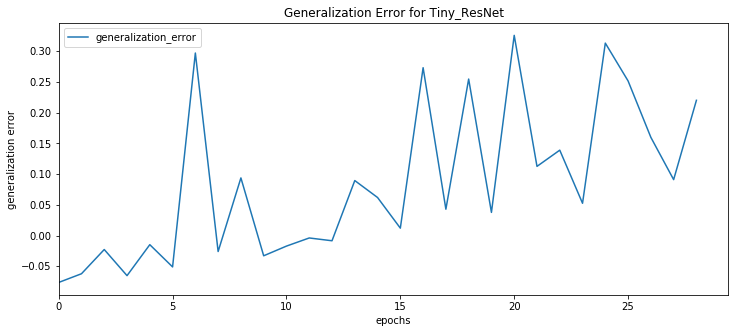

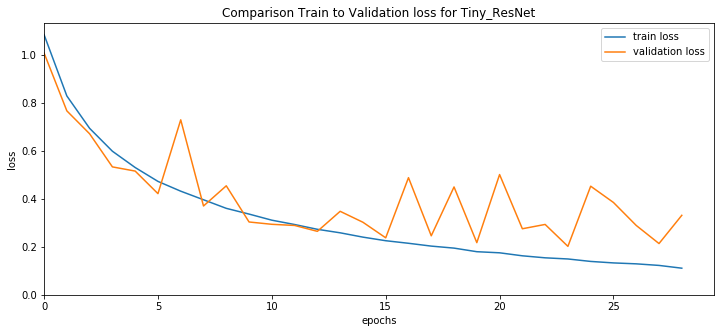

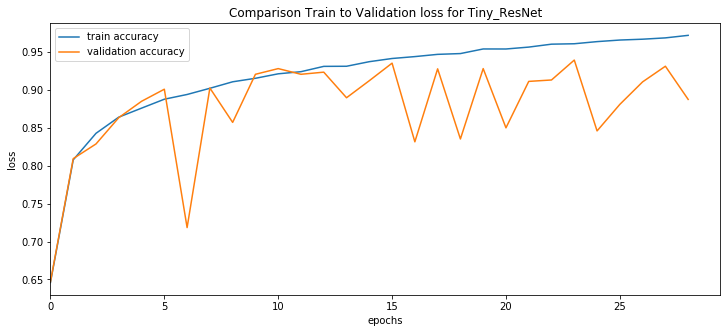

In [44]:
generalization_error_tiny_resnet = tiny_resnet_data.val_loss - tiny_resnet_data.loss

#plot
plt.figure(figsize=(12,5))
plt.plot(generalization_error_tiny_resnet, label='generalization_error')
plt.title("Generalization Error for Tiny_ResNet")
plt.xlabel('epochs')
plt.ylabel('generalization error')
plt.xlim(xmin = 0)
plt.legend()
plt.show()

plt.figure(figsize=(12,5))
plt.plot(tiny_resnet_data.loss, label = 'train loss')
plt.plot(tiny_resnet_data.val_loss, label = 'validation loss')
plt.title("Comparison Train to Validation loss for Tiny_ResNet")
plt.xlabel('epochs')
plt.ylabel('loss')
plt.xlim(xmin = 0)
plt.ylim(ymin = 0)
plt.legend()
plt.show()

plt.figure(figsize=(12,5))
plt.plot(tiny_resnet_data.accuracy, label = 'train accuracy')
plt.plot(tiny_resnet_data.val_accuracy, label = 'validation accuracy')
plt.title("Comparison Train to Validation loss for Tiny_ResNet")
plt.xlabel('epochs')
plt.ylabel('loss')
plt.xlim(xmin = 0)

plt.legend()
plt.show()

---

## Plain Conv

In [47]:
# Name of the checkpoint files
plain_conv_checkpoint = os.path.join(checkpoint_dir, "plain_conv_ckpt_{epoch}")

In [48]:
#Plain Conv
inputs3 = Input(shape = (224, 224, 1))

#conv 1
model3 = Conv2D(filters = 32, 
               kernel_size = 5, padding = 'same', 
               name = 'conv_1_5x5', 
               activation = 'relu', 
               kernel_initializer = he_uniform())(inputs3)
model3 = BatchNormalization(name = 'bn_1')(model3)

#decrease dimensions
model3 = MaxPool2D(pool_size = 3, strides = 2)(model3)

#conv 2
model3 = Conv2D(filters = 32, 
               kernel_size = 3, padding = 'same', 
               name = 'conv_2_3x3', 
               activation = 'relu', 
               kernel_initializer = he_uniform())(model3)
model3 = BatchNormalization(name = 'bn_2')(model3)

#conv 3
model3 = Conv2D(filters = 32, 
               kernel_size = 3, padding = 'same', 
               name = 'conv_3_3x3', 
               activation = 'relu', 
               kernel_initializer = he_uniform())(model3)
model3 = BatchNormalization(name = 'bn_3')(model3)

#conv 4
model3 = Conv2D(filters = 64, 
               kernel_size = 3, strides = 2, padding = 'same', 
               name = 'conv_4_3x3', 
               activation = 'relu', 
               kernel_initializer = he_uniform())(model3)
model3 = BatchNormalization(name = 'bn_4')(model3)

#conv 5
model3 = Conv2D(filters = 64, 
               kernel_size = 3, padding = 'same', 
               name = 'conv_5_3x3', 
               activation = 'relu', 
               kernel_initializer = he_uniform())(model3)
model3 = BatchNormalization(name = 'bn_5')(model3)

#conv 6
model3 = Conv2D(filters = 64, 
               kernel_size = 3, padding = 'same', 
               name = 'conv_6_3x3', 
               activation = 'relu', 
               kernel_initializer = he_uniform())(model3)
model3 = BatchNormalization(name = 'bn_6')(model3)

#conv 7
model3 = Conv2D(filters = 128, 
               kernel_size = 3, strides = 2, padding = 'same', 
               name = 'conv_7_3x3', 
               activation = 'relu', 
               kernel_initializer = he_uniform())(model3)
model3 = BatchNormalization(name = 'bn_7')(model3)

#1x1 conv block substituting fully connected layer exit
model3 = Conv2D(filters = 4, kernel_size = 1, strides = 1, name = 'conv_output_1x1', kernel_initializer = he_uniform())(model3)
model3 = BatchNormalization(name = 'bn_output')(model3)
model3 = GlobalAveragePooling2D()(model3)
classifications3 = Activation('softmax')(model3)



In [65]:
plain_conv = Model(inputs = inputs3, outputs = classifications3)

In [66]:
plain_conv.compile(optimizer = get_optimizer(0.001),
                  loss = CategoricalCrossentropy(),
                  metrics=['accuracy'])

In [68]:
#plain_conv.summary()

In [69]:
save_histories['Plain_Conv'] = plain_conv.fit(
    train_dataset, 
    epochs = EPOCHS,
    validation_data = val_dataset,
    steps_per_epoch = len(list(list_train))//BATCH_SIZE, 
    validation_steps = len(list(list_val))//BATCH_SIZE,
    initial_epoch = 0,
    callbacks = [get_modelcheckpoint(plain_conv_checkpoint),
                get_tensorboard_callback('Plain_Conv'),
                earlystopping_callback])

Train for 450 steps, validate for 50 steps
Epoch 1/30
450/450 [==============================] - 64s 142ms/step - loss: 1.0144 - accuracy: 0.6848 - val_loss: 1.1335 - val_accuracy: 0.5337
Epoch 2/30
450/450 [==============================] - 62s 137ms/step - loss: 0.7299 - accuracy: 0.8380 - val_loss: 0.6681 - val_accuracy: 0.7953
Epoch 3/30
450/450 [==============================] - 61s 136ms/step - loss: 0.5902 - accuracy: 0.8728 - val_loss: 0.5488 - val_accuracy: 0.8813
Epoch 4/30
450/450 [==============================] - 64s 142ms/step - loss: 0.4988 - accuracy: 0.8935 - val_loss: 0.5512 - val_accuracy: 0.8656
Epoch 5/30
450/450 [==============================] - 62s 138ms/step - loss: 0.4312 - accuracy: 0.9074 - val_loss: 0.4836 - val_accuracy: 0.8778
Epoch 6/30
450/450 [==============================] - 61s 136ms/step - loss: 0.3757 - accuracy: 0.9189 - val_loss: 0.4356 - val_accuracy: 0.8844
Epoch 7/30
450/450 [==============================] - 62s 139ms/step - loss: 0.3354 - a

In [70]:
#plain_conv_model_path = "model_save\\plain_conv"
#plain_conv.save(plain_conv_model_path)

INFO:tensorflow:Assets written to: model_save\plain_conv\assets


In [47]:
plain_conv_data = pd.read_csv('Plain_Conv.csv', usecols = ['loss', 'accuracy', 'val_loss','val_accuracy'])
#= get_data_to_csv(save_histories.get('Plain_Conv'), 'Plain_Conv')
plain_conv_data.sample()

,loss,accuracy,val_loss,val_accuracy
12,0.184945,0.962049,0.342709,0.900312


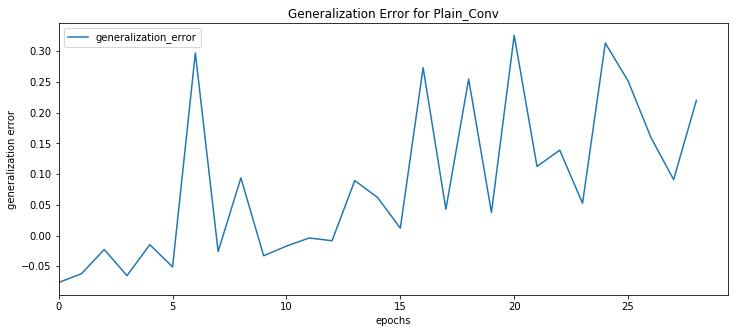

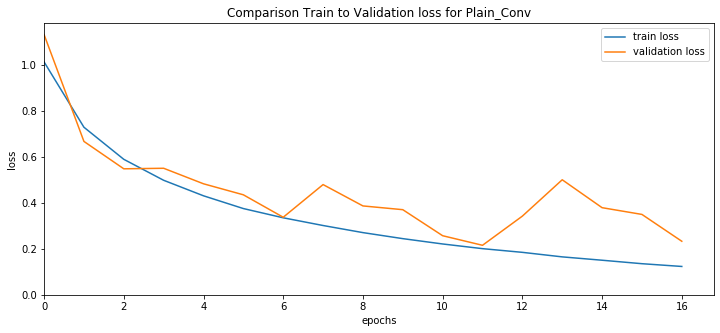

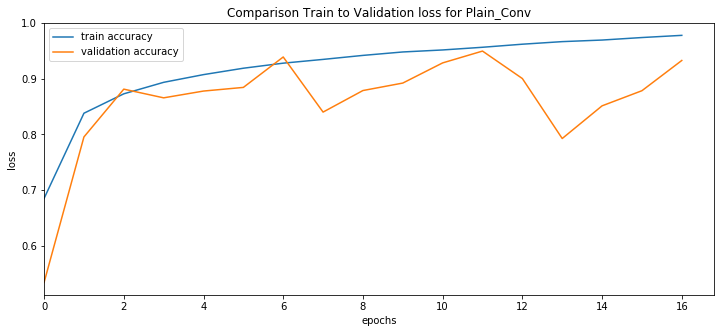

In [48]:
generalization_error_plain_conv = plain_conv_data.val_loss - plain_conv_data.loss

#plot
plt.figure(figsize=(12,5))
plt.plot(generalization_error_tiny_resnet, label='generalization_error')
plt.title("Generalization Error for Plain_Conv")
plt.xlabel('epochs')
plt.ylabel('generalization error')
plt.xlim(xmin = 0)
plt.legend()
plt.show()

plt.figure(figsize=(12,5))
plt.plot(plain_conv_data.loss, label = 'train loss')
plt.plot(plain_conv_data.val_loss, label = 'validation loss')
plt.title("Comparison Train to Validation loss for Plain_Conv")
plt.xlabel('epochs')
plt.ylabel('loss')
plt.xlim(xmin = 0)
plt.ylim(ymin = 0)
plt.legend()
plt.show()

plt.figure(figsize=(12,5))
plt.plot(plain_conv_data.accuracy, label = 'train accuracy')
plt.plot(plain_conv_data.val_accuracy, label = 'validation accuracy')
plt.title("Comparison Train to Validation loss for Plain_Conv")
plt.xlabel('epochs')
plt.ylabel('loss')
plt.xlim(xmin = 0)

plt.legend()
plt.show()

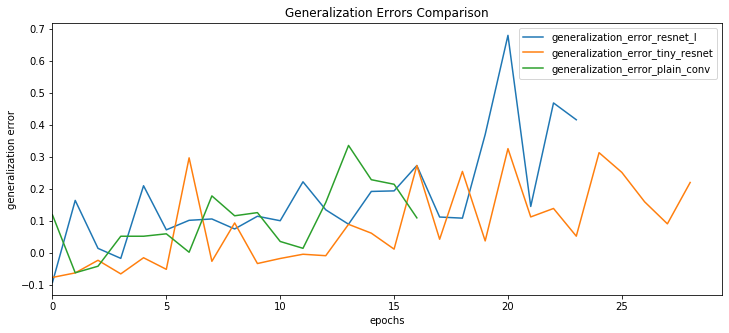

In [49]:
#Compare all three models generalization errors
plt.figure(figsize=(12,5))
plt.plot(generalization_error_resnet_l, label='generalization_error_resnet_l')
plt.plot(generalization_error_tiny_resnet, label='generalization_error_tiny_resnet')
plt.plot(generalization_error_plain_conv, label='generalization_error_plain_conv')
plt.title('Generalization Errors Comparison')
plt.xlabel('epochs')
plt.ylabel('generalization error')
plt.xlim(xmin = 0)
plt.legend()
plt.show()

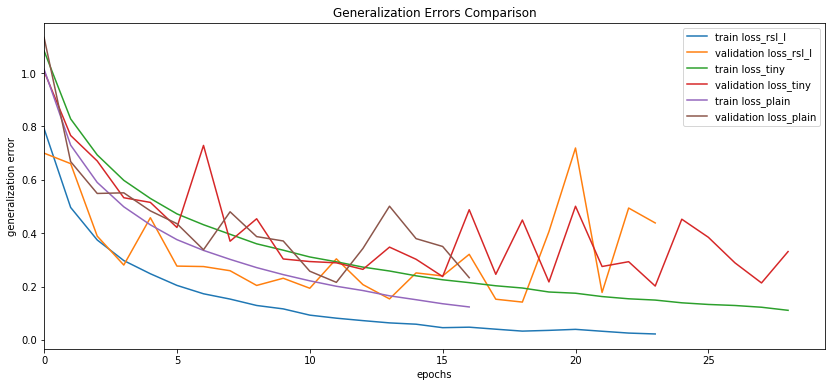

In [50]:
#Compare all three models generalization errors
plt.figure(figsize=(14,6))
plt.plot(resnet_data.loss, label = 'train loss_rsl_l')
plt.plot(resnet_data.val_loss, label = 'validation loss_rsl_l')
plt.plot(tiny_resnet_data.loss, label = 'train loss_tiny')
plt.plot(tiny_resnet_data.val_loss, label = 'validation loss_tiny')
plt.plot(plain_conv_data.loss, label = 'train loss_plain')
plt.plot(plain_conv_data.val_loss, label = 'validation loss_plain')
plt.title('Generalization Errors Comparison')
plt.xlabel('epochs')
plt.ylabel('generalization error')
plt.xlim(xmin = 0)
plt.legend()
plt.show()

We can see that generalization error (variance) increases in all of the models. Overfitting is more or less a problem everywhere. The most stable model seems to be the Tiny ResNet which stopped at the 25th epoch and has a lower generalization error, compared to the other two architectures.

This model is not as deep as the ResNet L but at the same time benefits from the advantages of the residual blocks structure.
On the other hand, the highest bias is observed in the Tiny ResNet model, meaning it has a problem with correctly classifying images in the training set. In short - our model is wrong to some extent and this level of "wrongness" is transferred to the validation set too.

The ResNet L is obvious "overfitter". It has a very low training error, compared to the rest. But at the same time, the validation error is pretty high. This one learns the training data too well and misses on the point of generalizing.

The Plain Conv seems to be in the middle but since our EarlyStopping callback was activated at such an early stage in the training we can suggest this one was going in the wrong direction too. 

Further, we will optimize our models by adjusting the learning rates based on what we saw in the first stage of this process. We will also test adding l2 regularization to one of the models (Tiny Resnet). It is not that common to use this type of regularization in convolutional neural networks (at least what I've heard :)) but in several papers, authors use a very small l2 weight regularization, which helps in the learning process. (Alex Krizhevsky et al.: http://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks, Karen Simonyan, and Andrew Zisserman: https://arxiv.org/abs/1409.1556)

 
Next steps:
 - Batch size will be 32 - We will use smaller value now in an attempt to minimize the generalization error of our models.
 - Add l2 regularization to our Tiny ResNet.
 - Add LearningRateSchedule to try to minimize the bias.
 - No change will be made in the resnet blocks (not in the scope of the project now).

---

## Tune models

In [49]:
BATCH_SIZE_TUNE = 32 #test the assumption the small batches give opportunity for better generalization
L2_REG = 5e-4

## ResNet_L_Tune

In [50]:
# Name of the checkpoint files
resnet_l_tune_checkpoint = os.path.join(checkpoint_dir, "resnet_l_tune_ckpt_{epoch}")

In [51]:
#ResNet_L_tune
#add kernel regularizer to the conv layers - the value is taken from Alex Krizhevsky, et al.

inputs = Input(shape = (224, 224, 1))

#conv 1
model = Conv2D(filters = 64, 
               kernel_size = 7, strides = 2, padding = 'same', 
               name = 'conv_1_7x7', 
               kernel_initializer = he_uniform())(inputs)
model = BatchNormalization(name = 'bn_1')(model)
model = Activation('relu')(model)

#conv 2
model = Conv2D(filters = 64, 
               kernel_size = 5, padding = 'same', 
               name = 'conv_2_5x5', 
               kernel_initializer = he_uniform())(model)
model = BatchNormalization(name = 'bn_2')(model)
model = Activation('relu')(model)

#decrease dimensions
model = MaxPool2D(pool_size = 3, strides = 2)(model)

#resnet 1
model = res_net_block2(model, 3, 1, 'a', 64)

#resnet 2
model = res_net_block3(model, 3, 2, 'b', filters = [64, 64, 128])

#decrease dimensions 
model = Conv2D(filters = 128, 
               kernel_size = 3, strides = 2, padding = 'valid', 
               activation = 'relu', 
               name = 'conv_3_3x3', 
               kernel_initializer = he_uniform())(model) 

#resnet 3
model = res_net_block2(model, 3, 3, 'c', 128)

#resnet 4
model = res_net_block3(model, 3, 4, 'd', filters = [128, 128, 256])

#1x1 conv block substituting fully connected layer exit
model = Conv2D(filters = 4, 
               kernel_size = 1, 
               strides = 1, 
               name = 'conv_output_1x1', 
               kernel_initializer = he_uniform())(model)
model = BatchNormalization(name = 'bn_output')(model)
model = GlobalAveragePooling2D()(model)
classifications = Activation('softmax')(model)

In [110]:
resnet_l_tune = Model(inputs = inputs, outputs = classifications)

In [103]:
#resnet_l_tune.summary()

In [111]:
def scheduler_rst_l_tune(epoch):
    if epoch < 3:
        return 1e-3
    elif epoch < 18:
        return 1e-4
    else:
        return 1e-5

In [112]:
resnet_l_tune.compile(optimizer = Adam(learning_rate = 0.001),
                     loss = CategoricalCrossentropy(),
                     metrics=['accuracy'])

In [113]:
save_histories['ResNet_L_Tune'] = resnet_l_tune.fit(
    train_dataset,
    epochs = EPOCHS,
    validation_data = val_dataset,
    steps_per_epoch = len(list(list_train))//BATCH_SIZE_TUNE, 
    validation_steps = len(list(list_val))//BATCH_SIZE_TUNE,
    initial_epoch = 0,
    callbacks = [get_modelcheckpoint(resnet_l_tune_checkpoint),
                get_tensorboard_callback('ResNet_L_Tune'),
                earlystopping_callback,
                learning_rate_scheduler(scheduler_rst_l_tune)]) 


Train for 900 steps, validate for 100 steps
Epoch 1/30
900/900 [==============================] - 194s 215ms/step - loss: 0.6144 - accuracy: 0.8617 - val_loss: 0.7781 - val_accuracy: 0.7041
Epoch 2/30
900/900 [==============================] - 191s 212ms/step - loss: 0.3132 - accuracy: 0.9387 - val_loss: 0.2602 - val_accuracy: 0.9384
Epoch 3/30
900/900 [==============================] - 191s 212ms/step - loss: 0.2137 - accuracy: 0.9552 - val_loss: 0.2464 - val_accuracy: 0.9344
Epoch 4/30
900/900 [==============================] - 190s 211ms/step - loss: 0.1335 - accuracy: 0.9774 - val_loss: 0.1602 - val_accuracy: 0.9625
Epoch 5/30
900/900 [==============================] - 190s 211ms/step - loss: 0.1149 - accuracy: 0.9835 - val_loss: 0.1506 - val_accuracy: 0.9628
Epoch 6/30
900/900 [==============================] - 190s 211ms/step - loss: 0.1017 - accuracy: 0.9873 - val_loss: 0.1543 - val_accuracy: 0.9641
Epoch 7/30
900/900 [==============================] - 190s 211ms/step - loss: 0.

In [114]:
#rst_l_tune_model_path = "model_save\\resnet_l_tune"
#resnet_l_tune.save(rst_l_tune_model_path)

INFO:tensorflow:Assets written to: model_save\resnet_l_tune\assets


This one is simply too good to be true :)
The model continues to experience a big variance. It is not good at generalization. In this case, more data on the training set could affect the results positively. 

## Tiny_ResNet_Tune

We have added l2 regularization and removed the dropout from our model (more on this matter here: https://www.reddit.com/r/MachineLearning/comments/5l3f1c/d_what_happened_to_dropout/).

In [52]:
# Name of the checkpoint files
tiny_resnet_tune_checkpoint = os.path.join(checkpoint_dir, "tiny_resnet_tune_ckpt_{epoch}")

In [53]:
#Tiny ResNet Tune
inputs2 = Input(shape = (224, 224, 1))

#conv 1
model2 = Conv2D(filters = 32, 
               kernel_size = 7, strides = 2, padding = 'same', 
               name = 'conv_1_7x7', 
               kernel_initializer = he_uniform(),
               kernel_regularizer = l2(L2_REG))(inputs2)
model2 = BatchNormalization(name = 'bn_1')(model2)
model2 = Activation('relu')(model2)

#decrease dimensions
model2 = MaxPool2D(pool_size = 3, strides = 2)(model2)

#resnet 1
model2 = res_net_block2(model2, 3, 1, 'a', 32)

#resnet 2
model2 = res_net_block3(model2, 3, 2, 'b', filters = [32, 32, 64])

#decrease dimensions 
model2 = Conv2D(filters = 128, 
               kernel_size = 3, strides = 2, padding = 'valid', 
               activation = 'relu', 
               name = 'conv_3_3x3', 
               kernel_initializer = he_uniform(),
               kernel_regularizer = l2(L2_REG))(model2) 

#1x1 conv block substituting fully connected layer exit
model2 = Conv2D(filters = 4, kernel_size = 1, strides = 1, name = 'conv_output_1x1', kernel_initializer = he_uniform())(model2)
model2 = BatchNormalization(name = 'bn_output')(model2)
model2 = GlobalAveragePooling2D()(model2)
classifications2 = Activation('softmax')(model2)

In [119]:
tiny_resnet_tune = Model(inputs = inputs2, outputs = classifications2)

In [121]:
#tiny_resnet_tune.summary()

In [128]:
def scheduler_tiny_tune(epoch):
    if epoch < 6:
        return 1e-3
    elif epoch < 16:
        return 1e-4
    else:
        return 1e-5
    
def scheduler_tiny_tune2(epoch): #run it from 25th on
    return 1e-6    

In [124]:
tiny_resnet_tune.compile(optimizer = Adam(learning_rate = 0.001),
                     loss = CategoricalCrossentropy(),
                     metrics=['accuracy'])

In [129]:
save_histories['Tiny_ResNet_Tune'] = tiny_resnet_tune.fit(
    train_dataset,
    epochs = EPOCHS,
    validation_data = val_dataset,
    steps_per_epoch = len(list(list_train))//BATCH_SIZE_TUNE, 
    validation_steps = len(list(list_val))//BATCH_SIZE_TUNE,
    initial_epoch = 25,
    callbacks = [get_modelcheckpoint(tiny_resnet_tune_checkpoint),
                get_tensorboard_callback('Tiny_ResNet_Tune'),
                earlystopping_callback,
                learning_rate_scheduler(scheduler_tiny_tune2)]) 


Train for 900 steps, validate for 100 steps
Epoch 26/30
900/900 [==============================] - 55s 61ms/step - loss: 0.1905 - accuracy: 0.9629 - val_loss: 0.1993 - val_accuracy: 0.9525
Epoch 27/30
900/900 [==============================] - 55s 61ms/step - loss: 0.1896 - accuracy: 0.9628 - val_loss: 0.1992 - val_accuracy: 0.9525
Epoch 28/30
900/900 [==============================] - 55s 61ms/step - loss: 0.1908 - accuracy: 0.9620 - val_loss: 0.1994 - val_accuracy: 0.9519
Epoch 29/30
900/900 [==============================] - 55s 61ms/step - loss: 0.1895 - accuracy: 0.9631 - val_loss: 0.1992 - val_accuracy: 0.9528
Epoch 30/30
900/900 [==============================] - 55s 61ms/step - loss: 0.1902 - accuracy: 0.9613 - val_loss: 0.1991 - val_accuracy: 0.9528


In [130]:
#tiny_resnet_tune_model_path = "model_save\\tiny_resnet_tune"
#tiny_resnet_tune.save(tiny_resnet_tune_model_path)

INFO:tensorflow:Assets written to: model_save\tiny_resnet_tune\assets


Early stopping was activated after the 25th epoch. We reduced again the learning rate and ran it in an attempt to minimize the loss. The model did not show progress. Adjusting the learning rate through the epochs helped minimize the variance and reduce overfitting. Actually our model is doing good with the generalization issue. We see over 95% accuracy on the training and the validation sets. But the bias continued to be high. Again, more data will be useful in this case.
The answer to this Reddit question (https://www.reddit.com/r/deeplearning/comments/aev233/high_loss_despite_high_accuracy/) might be used as a good starting point for tuning the model. It seems that "punishing the model for its complexity" might have been too harsh for our small-sized neural network. So we will make an update on this and train the model again but without the l2 regularization. 

---

## Tiny ResNet Tune2

In [56]:
def scheduler_tiny_tune2(epoch):
    if epoch < 6:
        return 1e-3
    elif epoch < 16:
        return 1e-4
    elif epoch < 25:
        return 1e-5
    else:
        return 1e-6

In [57]:
# Name of the checkpoint files
tiny_resnet_tune_checkpoint2 = os.path.join(checkpoint_dir, "tiny_resnet_tune_ckpt2_{epoch}")

In [58]:
#Tiny ResNet Tune2
inputs2 = Input(shape = (224, 224, 1))

#conv 1
model2 = Conv2D(filters = 32, 
               kernel_size = 7, strides = 2, padding = 'same', 
               name = 'conv_1_7x7', 
               kernel_initializer = he_uniform())(inputs2)
model2 = BatchNormalization(name = 'bn_1')(model2)
model2 = Activation('relu')(model2)

#decrease dimensions
model2 = MaxPool2D(pool_size = 3, strides = 2)(model2)

#resnet 1
model2 = res_net_block2(model2, 3, 1, 'a', 32)

#resnet 2
model2 = res_net_block3(model2, 3, 2, 'b', filters = [32, 32, 64])

#decrease dimensions 
model2 = Conv2D(filters = 128, 
               kernel_size = 3, strides = 2, padding = 'valid', 
               activation = 'relu', 
               name = 'conv_3_3x3', 
               kernel_initializer = he_uniform())(model2) 

#1x1 conv block substituting fully connected layer exit
model2 = Conv2D(filters = 4, kernel_size = 1, strides = 1, name = 'conv_output_1x1', kernel_initializer = he_uniform())(model2)
model2 = BatchNormalization(name = 'bn_output')(model2)
model2 = GlobalAveragePooling2D()(model2)
classifications2 = Activation('softmax')(model2)

In [42]:
tiny_resnet_tune2 = Model(inputs = inputs2, outputs = classifications2)

In [43]:
tiny_resnet_tune2.compile(optimizer = Adam(learning_rate = 0.001),
                     loss = CategoricalCrossentropy(),
                     metrics=['accuracy'])

In [50]:
save_histories['Tiny_ResNet_Tune2'] = tiny_resnet_tune2.fit(
    train_dataset,
    epochs = EPOCHS,
    validation_data = val_dataset,
    steps_per_epoch = len(list(list_train))//BATCH_SIZE_TUNE, 
    validation_steps = len(list(list_val))//BATCH_SIZE_TUNE,
    initial_epoch = 0,
    callbacks = [get_modelcheckpoint(tiny_resnet_tune_checkpoint2),
                get_tensorboard_callback('Tiny_ResNet_Tune2'),
                earlystopping_callback,
                learning_rate_scheduler(scheduler_tiny_tune2)]) 


Train for 900 steps, validate for 100 steps
Epoch 1/30
900/900 [==============================] - 201s 223ms/step - loss: 0.9114 - accuracy: 0.7459 - val_loss: 0.6844 - val_accuracy: 0.8434
Epoch 2/30
900/900 [==============================] - 55s 61ms/step - loss: 0.6126 - accuracy: 0.8583 - val_loss: 0.4949 - val_accuracy: 0.8834
Epoch 3/30
900/900 [==============================] - 54s 60ms/step - loss: 0.4741 - accuracy: 0.8832 - val_loss: 0.4563 - val_accuracy: 0.89190s - l
Epoch 4/30
900/900 [==============================] - 55s 61ms/step - loss: 0.3879 - accuracy: 0.9029 - val_loss: 0.3807 - val_accuracy: 0.9034
Epoch 5/30
900/900 [==============================] - 55s 61ms/step - loss: 0.3296 - accuracy: 0.9143 - val_loss: 0.2936 - val_accuracy: 0.9337
Epoch 6/30
900/900 [==============================] - 55s 61ms/step - loss: 0.2841 - accuracy: 0.9251 - val_loss: 0.3977 - val_accuracy: 0.8750
Epoch 7/30
900/900 [==============================] - 55s 61ms/step - loss: 0.2318 -

In [46]:
#tiny_resnet_tune2_path = "model_save\\tiny_resnet_tune2"
#tiny_resnet_tune2.save(tiny_resnet_tune2_path)

The results from Tune2 are encouraging. The training loss fell as well as the validation loss. We will now adjust the learning rate schedule.

---

## Tiny ResNet Tune3

In [54]:
def scheduler_tiny_tune3(epoch):
    if epoch < 10:
        return 1e-3
    elif epoch < 20:
        return 1e-4
    else:
        return 1e-5

In [55]:
# Name of the checkpoint files
tiny_resnet_tune_checkpoint3 = os.path.join(checkpoint_dir, "tiny_resnet_tune_ckpt3_{epoch}")

In [56]:
tiny_resnet_tune3 = Model(inputs = inputs2, outputs = classifications2)

In [52]:
tiny_resnet_tune3.compile(optimizer = Adam(learning_rate = 0.001),
                     loss = CategoricalCrossentropy(),
                     metrics=['accuracy'])

In [55]:
save_histories['Tiny_ResNet_Tune3'] = tiny_resnet_tune3.fit(
    train_dataset,
    epochs = EPOCHS,
    validation_data = val_dataset,
    steps_per_epoch = len(list(list_train))//BATCH_SIZE_TUNE, 
    validation_steps = len(list(list_val))//BATCH_SIZE_TUNE,
    initial_epoch = 0,
    callbacks = [get_modelcheckpoint(tiny_resnet_tune_checkpoint3),
                get_tensorboard_callback('Tiny_ResNet_Tune3'),
                earlystopping_callback,
                learning_rate_scheduler(scheduler_tiny_tune3)]) 


Train for 900 steps, validate for 100 steps
Epoch 1/30
900/900 [==============================] - 198s 220ms/step - loss: 0.9186 - accuracy: 0.7413 - val_loss: 0.7454 - val_accuracy: 0.7294
Epoch 2/30
900/900 [==============================] - 47s 53ms/step - loss: 0.6134 - accuracy: 0.8540 - val_loss: 0.5279 - val_accuracy: 0.8584
Epoch 3/30
900/900 [==============================] - 47s 53ms/step - loss: 0.4773 - accuracy: 0.8804 - val_loss: 0.4184 - val_accuracy: 0.8922
Epoch 4/30
900/900 [==============================] - 47s 53ms/step - loss: 0.3932 - accuracy: 0.8988 - val_loss: 0.4107 - val_accuracy: 0.8853
Epoch 5/30
900/900 [==============================] - 47s 53ms/step - loss: 0.3318 - accuracy: 0.9124 - val_loss: 0.7766 - val_accuracy: 0.7447
Epoch 6/30
900/900 [==============================] - 47s 53ms/step - loss: 0.2858 - accuracy: 0.9252 - val_loss: 0.3194 - val_accuracy: 0.9013
Epoch 7/30
900/900 [==============================] - 47s 53ms/step - loss: 0.2488 - accur

![alt text](tiny_resnet_train_results.png "Tiny ResNet Train Tuning Results")
Figure 4: Tany ResNet results for train data

![alt text](tiny_resnet_validation_results.png "Tiny ResNet Tuning Validation Results")
Figure 5: Tiny ResNet results for validation data

The plotted results for the tiny resnet model are somehow satisfying. in Tiny_ResNet_Tune3 we were able to achieve training loss below 10%. This came with increasing variance, compared to version Tune2. The result in Tune3, compared to the initial Tiny ResNet is very good because not only we decreased the loss by updating the learning rate schedule. We also decreased variance significantly.  

![alt text](tiny_resnet_accuracy_results.png "Tiny ResNet Accuracy Results")
Figure 5: Tiny ResNet accuracy results

Tune3 has the best training and validation accuracy, compared to all previous models, including the initial Tiny ResNet. It can be seen that the variance in Tune3 increased, compared to the other Tune models (the early stop was triggered).

Tiny Resnet Tune3 is the best classification model so far. The tuning we performed included only updates of the learning rate by a factor of 0.1 at 10th, 20th, and until the 30th epoch. We may be able to achieve better results with additional adjusting of the learning rate schedule. 

More data will also provide more stability to the model.

In [75]:
tiny_resnet_evaluation = Model(inputs = inputs2, outputs = classifications2)

In [65]:
#latest = tf.train.latest_checkpoint(checkpoint_dir)
#latest

'training_checkpoints\\tiny_resnet_tune_ckpt3_28'

In [76]:
tiny_resnet_evaluation.load_weights('training_checkpoints\\tiny_resnet_tune_ckpt3_28')

In [77]:
tiny_resnet_evaluation.compile(optimizer = Adam(learning_rate = 0.001),
                               loss = CategoricalCrossentropy(),
                               metrics=['accuracy'])

In [78]:
tiny_evaluation = tiny_resnet_evaluation.evaluate(test_dataset, 
                                steps = len(list(list_test))//BATCH_SIZE_TUNE,
                                callbacks = [get_tensorboard_callback('Tiny_ResNet_Tune3_Evaluate')])

25/25 [==============================] - 1s 27ms/step - loss: 0.0632 - accuracy: 0.9925


The results of the testing set actually look pretty amazing. We have a 6.32% loss and 99.25% accuracy. This could be due to the fact we have a very small amount of testing data - only 200 OCT scans from each class or due to underfitting of the training/val data. Nevertheless, this model shows the potential for further improvement. 

In [82]:
predictions = tiny_resnet_evaluation.predict(test_dataset, steps = len(list(list_test))//BATCH_SIZE_TUNE)
predictions

array([[5.3189388e-03, 9.6747053e-01, 1.3886904e-02, 1.3323612e-02],
       [3.6503773e-03, 9.4433519e-04, 9.9319249e-01, 2.2128006e-03],
       [1.7692405e-03, 1.0559376e-03, 9.9065268e-01, 6.5222057e-03],
       ...,
       [9.8262858e-01, 1.3280472e-03, 1.0375494e-02, 5.6679645e-03],
       [9.8866093e-01, 3.1713890e-03, 5.5638384e-03, 2.6038056e-03],
       [1.9569274e-03, 2.7118509e-03, 3.0221099e-02, 9.6511012e-01]],
      dtype=float32)

## Plain_Conv_Tune

In [57]:
# Name of the checkpoint files
plain_conv_tune_checkpoint = os.path.join(checkpoint_dir, "plain_conv_tune_ckpt_{epoch}")

In [58]:
plain_conv_tune = Model(inputs = inputs3, outputs = classifications3)

In [59]:
def scheduler_plain_conv_tune(epoch):
    if epoch < 7:
        return 1e-4
    else:
        return 1e-5
    
def scheduler_plain_conv_tune_reloaded(epoch):
    if epoch < 40:
        return 1e-5
    else:
        return 1e-6

In [44]:
#latest = tf.train.latest_checkpoint(checkpoint_dir)
#latest

'training_checkpoints\\plain_conv_tune_ckpt_30'

In [45]:
plain_conv_tune.compile(optimizer = Adam(learning_rate = 1e-5),
                     loss = CategoricalCrossentropy(),
                     metrics=['accuracy'])

In [46]:
#unstable electricity and we have to do the job again!
plain_conv_tune.load_weights('training_checkpoints\\plain_conv_tune_ckpt_30')

In [47]:
save_histories['Plain_Conv_Tune'] = plain_conv_tune.fit(
    train_dataset,
    epochs = 50,
    validation_data = val_dataset,
    steps_per_epoch = len(list(list_train))//BATCH_SIZE_TUNE, 
    validation_steps = len(list(list_val))//BATCH_SIZE_TUNE,
    initial_epoch = 30,
    callbacks = [get_modelcheckpoint(plain_conv_tune_checkpoint),
                get_tensorboard_callback('Plain_Conv_Tune'),
                earlystopping_callback,
                learning_rate_scheduler(scheduler_plain_conv_tune)]) 

Train for 900 steps, validate for 100 steps
Epoch 31/50
900/900 [==============================] - 241s 268ms/step - loss: 0.6231 - accuracy: 0.8797 - val_loss: 0.5847 - val_accuracy: 0.9006
Epoch 32/50
900/900 [==============================] - 123s 137ms/step - loss: 0.6206 - accuracy: 0.8804 - val_loss: 0.5778 - val_accuracy: 0.8984
Epoch 33/50
900/900 [==============================] - 123s 136ms/step - loss: 0.6179 - accuracy: 0.8810 - val_loss: 0.5837 - val_accuracy: 0.9038
Epoch 34/50
900/900 [==============================] - 125s 139ms/step - loss: 0.6141 - accuracy: 0.8818 - val_loss: 0.5755 - val_accuracy: 0.9056
Epoch 35/50
900/900 [==============================] - 124s 138ms/step - loss: 0.6126 - accuracy: 0.8815 - val_loss: 0.5747 - val_accuracy: 0.9003
Epoch 36/50
900/900 [==============================] - 124s 138ms/step - loss: 0.6098 - accuracy: 0.8822 - val_loss: 0.5727 - val_accuracy: 0.9066
Epoch 37/50
900/900 [==============================] - 126s 140ms/step - l

This model had the highest loss value. It did not show good accuracy results. We may have to work to make it deeper and to increase the number of convolutional filters. Here we will update the learning rate schedule.

In [1]:
#plain_conv_tune_model_path = "model_save\\plain_conv_tune"
#plain_conv_tune.save(plain_conv_tune_model_path)

In [101]:
# Name of the checkpoint files
plain_conv_tune2_checkpoint = os.path.join(checkpoint_dir, "plain_conv_tune2_ckpt_{epoch}")

In [102]:
def scheduler_plain_conv_tune2(epoch):
    if epoch < 7:
        return 1e-3
    elif epoch < 15:
        return 1e-4
    else:
        return 1e-5

In [103]:
plain_conv_tune2 = Model(inputs = inputs3, outputs = classifications3)

In [104]:
plain_conv_tune2.compile(optimizer = Adam(learning_rate = 0.001),
                     loss = CategoricalCrossentropy(),
                     metrics=['accuracy'])

In [105]:
save_histories['Plain_Conv_Tune2'] = plain_conv_tune2.fit(
    train_dataset,
    epochs = 30,
    validation_data = val_dataset,
    steps_per_epoch = len(list(list_train))//BATCH_SIZE_TUNE, 
    validation_steps = len(list(list_val))//BATCH_SIZE_TUNE,
    initial_epoch = 0,
    callbacks = [get_modelcheckpoint(plain_conv_tune2_checkpoint),
                get_tensorboard_callback('Plain_Conv_Tune2'),
                earlystopping_callback,
                learning_rate_scheduler(scheduler_plain_conv_tune2)]) 

Train for 900 steps, validate for 100 steps
Epoch 1/30
900/900 [==============================] - 262s 291ms/step - loss: 0.8670 - accuracy: 0.7670 - val_loss: 0.7160 - val_accuracy: 0.7922
Epoch 2/30
900/900 [==============================] - 141s 157ms/step - loss: 0.5534 - accuracy: 0.8782 - val_loss: 0.5791 - val_accuracy: 0.8250
Epoch 3/30
900/900 [==============================] - 142s 158ms/step - loss: 0.4121 - accuracy: 0.9089 - val_loss: 0.3577 - val_accuracy: 0.9291
Epoch 4/30
900/900 [==============================] - 143s 159ms/step - loss: 0.3245 - accuracy: 0.9283 - val_loss: 0.3485 - val_accuracy: 0.9194
Epoch 5/30
900/900 [==============================] - 144s 160ms/step - loss: 0.2597 - accuracy: 0.9427 - val_loss: 0.2968 - val_accuracy: 0.9122
Epoch 6/30
900/900 [==============================] - 141s 156ms/step - loss: 0.2136 - accuracy: 0.9547 - val_loss: 0.3378 - val_accuracy: 0.8875
Epoch 7/30
900/900 [==============================] - 143s 159ms/step - loss: 0.

We were able to minimize the training loss significantly but the generalization error for this model is higher than the one achieved in the Tiny ResNet Tune3. The same applies to the accuracy metric.

# Conclusion

In this project, we applied the building blocks of the residual learning strategy to shallower networks. We compared three models, two with residual blocks and one plain fully convolutional structure. The tuning of the models consisted of adding l2 regularization and optimization of the learning rate. The best result that we have achieved is from Tiny ResNet Tune3 where training loss fell below 10% -loss: 0.0988 - accuracy: 0.9808 - val_loss: 0.1421 - val_accuracy: 0.9594.

Further improvement in the learning rate schedule leads to better results. Adding more data will be beneficial for all of the models. Adjusting the brightness of the images in the preprocessing stage may also improve the training process. We will develop this project by exploring possibilities for tuning other hyperparameters such as momentum or changing the activation function of the hidden layers.

---

# Additional cool stuff

We have a favorite model - Tiny ResNet Tune3.
So we can do some cool things like showing the convolutional filters of the model. (code reference: https://machinelearningmastery.com/how-to-visualize-filters-and-feature-maps-in-convolutional-neural-networks/)

*First, we will plot some convolutional filters.*

In [109]:
# summarize filter shapes
for layer in tiny_resnet_tune3.layers:
    # check for convolutional layer
    if 'conv' not in layer.name and 'res' not in layer.name:
        continue
    # get filter weights
    filters, biases = layer.get_weights()
    print(layer.name, filters.shape)

conv_1_7x7 (7, 7, 1, 32)
res_1a_branch_d (3, 3, 32, 32)
res_1a_branch_e (3, 3, 32, 32)
res_2b_branch_a (1, 1, 32, 32)
res_2b_branch_b (3, 3, 32, 32)
res_2b_branch_c (1, 1, 32, 64)
res_2b_branch_1 (1, 1, 32, 64)
conv_3_3x3 (3, 3, 64, 128)
conv_output_1x1 (1, 1, 128, 4)


In [112]:
# retrieve weights from the second hidden layer
filters, biases = tiny_resnet_tune3.layers[1].get_weights()

In [113]:
# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

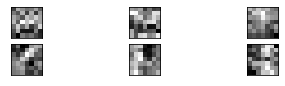

In [120]:
# plot first few filters
n_filters, ix = 6, 1
for i in range(n_filters):
    # get the filter
    f = filters[:, :, :, i]
    # plot each channel separately
    
    # specify subplot and turn of axis
    ax = plt.subplot(n_filters, 3, ix)
    ax.set_xticks([])
    ax.set_yticks([])
    # plot filter channel in grayscale
    plt.imshow(f[:, :, 0], cmap = 'gray')
    ix += 1
# show the figure
plt.show()

#### Suggestions 
As a way to improve the interpretability of our model, we will try to show feature maps and implement Grad-CAM. This would help us understand better what our neural network "sees" when filters are applied. 

### References

- Data: https://www.kaggle.com/paultimothymooney/kermany2018
- https://www.cell.com/cell/fulltext/S0092-8674(18)30154-5
- Paper for Residual Learning: https://arxiv.org/pdf/1512.03385.pdf
- ResNet: https://adventuresinmachinelearning.com/introduction-resnet-tensorflow-2/

- GAP - https://adventuresinmachinelearning.com/global-average-pooling-convolutional-neural-networks/
- GAP - https://arxiv.org/pdf/1312.4400.pdf
- CNN tutorial - https://adventuresinmachinelearning.com/convolutional-neural-networks-tutorial-tensorflow/ 
- Image Augmentation recommendations - https://machinelearningmastery.com/best-practices-for-preparing-and-augmenting-image-data-for-convolutional-neural-networks/
- Choose kernel initializer - https://www.machinecurve.com/index.php/2019/09/16/he-xavier-initialization-activation-functions-choose-wisely/
- https://pylessons.com/Keras-ResNet-tutorial/
- https://datascience.stackexchange.com/questions/37362/when-should-one-use-l1-l2-regularization-instead-of-dropout-layer-given-that-b
- https://datascience.stackexchange.com/questions/37021/why-does-adding-a-dropout-layer-improve-deep-machine-learning-performance-given/37024#37024
- learning rate, batch size, momentum, weight decay - https://arxiv.org/pdf/1803.09820.pdf
- https://stats.stackexchange.com/questions/436878/choosing-optimal-batch-size-contradicting-results
- https://www.quora.com/What-is-a-neuron-in-the-context-of-Convolutional-Neural-Network